In [1]:
%matplotlib inline

from datetime import datetime;now = datetime.now;t00=now()
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import copy

print('imports ready')
print(now()-t00)

imports ready
0:00:03.663180


In [2]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')

Mounted at /content/drive
done, mounted


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [5]:
# Autoencoder class
class CAE(nn.Module):
    def __init__(self,input_shape,k=1):
        super().__init__()
        
        # Stuff
        self.input_shape = input_shape
        self.batch_size = input_shape[0]

        self.lrelu = torch.nn.LeakyReLU(negative_slope=.02)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

        # Shapes and sizes
        #R = np.ones(shape=self.input_shape)
        #R = torch.tensor(R).float()

        bias_bool = False # Do you want padding or not 

        # Encoder
        self.enc_C1 = nn.Conv3d(in_channels=1,out_channels=int(4*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C2 = nn.Conv3d(in_channels=int(4*k),out_channels=int(8*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C3 = nn.Conv3d(in_channels=int(8*k),out_channels=int(16*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C4 = nn.Conv3d(in_channels=int(16*k),out_channels=int(32*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C5 = nn.Conv3d(in_channels=int(32*k),out_channels=int(64*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)

        self.batchNormE1 = nn.BatchNorm3d(int(4*k), affine=False)
        self.batchNormE2 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormE3 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormE4 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormE5 = nn.BatchNorm3d(int(64*k), affine=False)

        self.batchNormD1 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormD2 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormD3 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormD4 = nn.BatchNorm3d(int(4*k), affine=False)
        #self.batchNormD5 = nn.BatchNorm3d(int(4*k), affine=False)

        self.dec_C1 = nn.ConvTranspose3d(in_channels=int(64*k),out_channels=int(32*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C2 = nn.ConvTranspose3d(in_channels=int(32*k),out_channels=int(16*k),kernel_size=4, stride=2, padding=1,bias=bias_bool) 
        self.dec_C3 = nn.ConvTranspose3d(in_channels=int(16*k),out_channels=int(8*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C4 = nn.ConvTranspose3d(in_channels=int(8*k),out_channels=int(4*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C5 = nn.ConvTranspose3d(in_channels=int(4*k),out_channels=1,kernel_size=4, stride=2, padding=1,bias=bias_bool)

    def forward(self,hello):
      
        activation = self.relu( self.enc_C1(hello) )
        activation = self.batchNormE1(activation)

        activation = self.relu( self.enc_C2(activation) )
        activation = self.batchNormE2(activation)

        activation = self.relu( self.enc_C3(activation) )
        activation = self.batchNormE3(activation)

        activation = self.relu( self.enc_C4(activation) )
        activation = self.batchNormE4(activation)

        activation = self.relu( self.enc_C5(activation) )
        activation = self.batchNormE5(activation)

        activation = self.relu( self.dec_C1(activation))
        activation = self.batchNormD1(activation)

        activation = self.relu( self.dec_C2(activation) )
        activation = self.batchNormD2(activation)

        activation = self.relu( self.dec_C3(activation) )
        activation = self.batchNormD3(activation)

        activation = self.relu( self.dec_C4(activation) )
        activation = self.batchNormD4(activation)

        activation = self.relu( self.dec_C5(activation) )
        #activation = self.batchNormD5(activation)

        return activation


In [6]:
#torch.Size([5, 1, 64, 64, 64])

In [7]:
ofdir = os.path.join(os.path.curdir,'drive','My Drive','BC-MRI-AE','models')
session_name = 'CAE_Nolinear_adam_'
files = os.listdir(ofdir);files.sort()

[f'{i:02} | ' + files[i] for i in range(len(files))]

['00 | 5layer-128-batchNorme0_2020-10-30 17:42:37.536677',
 '01 | 5layer-128-batchNorme0_2020-10-30 18:05:44.127459',
 '02 | 5layer-128-batchNorme100_2020-10-30 17:51:55.266085',
 '03 | 5layer-128-batchNorme200_2020-10-30 18:01:00.232374',
 '04 | 5layer-128-batchNorme300_2020-10-30 18:10:17.562500',
 '05 | 5layer-128-batchNorme400_2020-10-30 18:19:18.357816',
 '06 | 5layer-128-batchNorme500_2020-10-30 18:28:12.677077',
 '07 | 5layer-256-batchNorme0_2020-10-30 18:52:15.625901',
 '08 | 5layer-256-batchNorme0_2020-10-30 18:53:18.397344',
 '09 | 5layer-256-batchNorme0_2020-11-03 16:53:14.450008',
 '10 | 5layer-256-batchNorme100_2020-10-30 19:02:06.470759',
 '11 | 5layer-256-batchNorme200_2020-10-30 19:10:55.199313',
 '12 | 5layer-256-batchNorme300_2020-10-30 19:19:43.830076',
 '13 | 5layer-256-batchNorme400_2020-10-30 19:28:31.226767',
 '14 | 5layer-256-batchNorme500_2020-10-30 19:37:20.298982']

In [10]:
i = 14
fn = os.path.join(ofdir,files[i])
print(fn)

model = CAE((1,1,64,64,64),k=.5) # Initiate mode
model.load_state_dict(torch.load(fn,map_location=torch.device('cpu')))
print('loaded')

./drive/My Drive/BC-MRI-AE/models/5layer-256-batchNorme500_2020-10-30 19:37:20.298982
loaded


In [21]:
def load_data(data_dir):
  #data_dir = './Data/ABIDE-64iso-normed'
  files = [file for file in os.listdir(data_dir) if '.npy' in file]; files.sort()
  data = np.array([np.load(os.path.join(data_dir,file)) for file in files])
  return data

In [22]:
os.listdir('./drive/My Drive/BC-MRI-AE/Data')

['ABIDE-64iso-normed', 'SFARI-64iso-normed']

In [23]:
df_abide = pd.read_csv('./drive/My Drive/BC-MRI-AE/CSVs/ABIDE-legend.csv')
df_sfari = pd.read_csv('./drive/My Drive/BC-MRI-AE/DS-use.csv')
SFARI_data = load_data('./drive/My Drive/BC-MRI-AE/Data/SFARI-64iso-normed')
sfari_subs = np.load('./drive/My Drive/BC-MRI-AE/sfari_subs.npy')
abide_subs = np.load('./drive/My Drive/BC-MRI-AE/abide_good_subs.npy')

print(df_abide.shape)
print(df_sfari.shape)
print(SFARI_data.shape)
print(sfari_subs.shape)
print(abide_subs.shape)

(1110, 78)
(136, 54)
(131, 64, 64, 64)
(131,)
(1071,)


In [24]:
t0 = now()
data_abide = load_data('./drive/My Drive/BC-MRI-AE/Data/ABIDE-64iso-normed')
#print(data.shape)

# Da = torch.tensor(data_abide[:,:,:,:,:]).float()
# Da = (Da-Da.min()) / (Da.max()-Da.min())

# D = torch.tensor(SFARI_data[:,:,:,:,:]).float()
# D = (D-D.min()) / (D.max()-D.min())

D = torch.tensor(SFARI_data[:,np.newaxis,:,:,:]).float()
Da = torch.tensor(data_abide[:,np.newaxis,:,:,:]).float()
print(now()-t0)

0:06:37.308185


In [26]:
def plot_pair(s,D):
  #s = 100
  input = D[s,0,:,:,:][np.newaxis,np.newaxis,:,:,:]
  output = model.forward(input)
  print(myLoss(input,output).item())

  plt.subplot(1,2,1)
  plt.imshow(input[0,0,32,:,:].numpy())
  plt.title('input')
  plt.subplot(1,2,2)
  plt.imshow(output[0,0,32,:,:].detach().numpy())
  plt.title('output')

  print(D.shape)

12248.798828125
torch.Size([131, 1, 64, 64, 64])


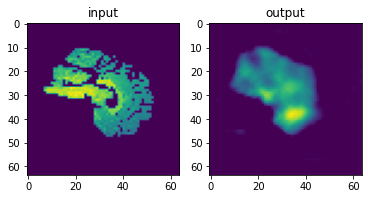

In [36]:
plot_pair(11,D)

1321.7646484375
torch.Size([1060, 1, 64, 64, 64])


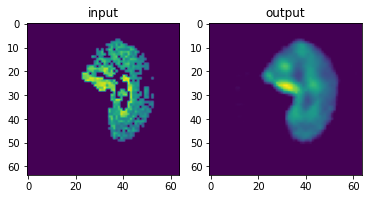

In [30]:
plot_pair(25,Da)

In [ ]:
model.enc_C3(model.enc_C2(model.enc_C1(input))).shape

torch.Size([1, 64, 8, 8, 8])

In [ ]:
#(64*64*64)/(64*8*8*8)

In [37]:
# SFARI reconstruction error
t0 = now()
errors = [myLoss(model.forward(D[s,0,:,:,:][np.newaxis,np.newaxis,:,:,:]),D[s,0,:,:,:][np.newaxis,np.newaxis,:,:,:]).item() for s in range(D.shape[0])]
errors = np.array(errors)
print(now()-t0)

0:00:03.166622


In [38]:
genes = [np.array(df_sfari.loc[df_sfari['BIDS ID']==sfari_subs[s]]['family_type'])[0] for s in range(len(sfari_subs))]
genes = np.array(genes)
ugene = np.unique(genes);ugene

array(['16p-deletion', '16p-duplication', '16p-triplication',
       '1q-deletion', '1q-duplication', 'non-familial-control'],
      dtype='<U20')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

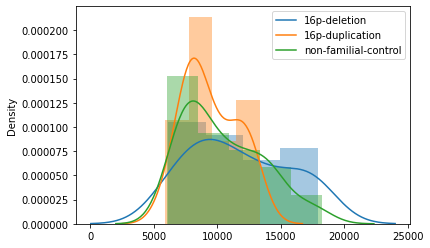

In [39]:
v1=errors[genes==ugene[0]]
v2=errors[genes==ugene[1]]
v3=errors[genes==ugene[5]]

sns.distplot(v1)
sns.distplot(v2)
sns.distplot(v3)

plt.legend([ugene[0],ugene[1],ugene[5]])

In [ ]:
sex = np.array([np.array(df_sfari.loc[df_sfari['BIDS ID']==sfari_subs[s]]['sex'])[0] for s in range(len(sfari_subs))])
age_years = np.array([np.array(df_sfari.loc[df_sfari['BIDS ID']==sfari_subs[s]]['age_years'])[0] for s in range(len(sfari_subs))])
best_full_scale_iq = np.array([np.array(df_sfari.loc[df_sfari['BIDS ID']==sfari_subs[s]]['best_full_scale_iq'])[0] for s in range(len(sfari_subs))])
bmi = np.array([np.array(df_sfari.loc[df_sfari['BIDS ID']==sfari_subs[s]]['htwhc.bmi'])[0] for s in range(len(sfari_subs))])

HC = np.array([np.array(df_sfari.loc[df_sfari['BIDS ID']==sfari_subs[s]]['htwhc.head_circum_z_score'])[0] for s in range(len(sfari_subs))])

sex[sex=='[]']=0
age_years[age_years=='[]']=0
best_full_scale_iq[best_full_scale_iq=='[]']=0
bmi[bmi=='[]']=0
HC[HC=='[]']=0

bmi = np.array([float(x) for x in bmi])
age_years = np.array([float(x) for x in age_years])
best_full_scale_iq = np.array([float(x) for x in best_full_scale_iq])
HC = np.array([float(x) for x in HC])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [ ]:
np.corrcoef(best_full_scale_iq[best_full_scale_iq>1],errors[best_full_scale_iq>1])[0,1]

-0.02252208822746871

In [ ]:
np.corrcoef(age_years[age_years>1],errors[age_years>1])[0,1]

-0.08617644179991811

In [ ]:
np.corrcoef(bmi[bmi>1],errors[bmi>1])[0,1]

-0.23911916199325026

In [ ]:
np.corrcoef(HC[HC>1],errors[HC>1])[0,1]

-0.02633050789677854

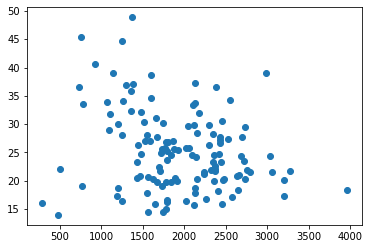

In [ ]:
plt.scatter(errors[bmi>1],bmi[bmi>1])

In [ ]:
disorder = np.array(df_sfari['svip_diagnosis_m1']);
np.unique(disorder)
dis = ['aspergers-disorder', 'autistic-disorder', 'no-diagnosis','non-spectrum-dx', 'pdd-nos-atypical-autism']
len([d for d in disorder if d in dis])

62

## ABIDE ERROR

In [ ]:
t0 = now()
errors = [myLoss(model.forward(D[i,:,:,:,:][np.newaxis,:,:,:,:]),D[i,:,:,:,:][np.newaxis,:,:,:,:]).item() for i in range(D.shape[0])]
errors = np.array(errors)
print('done')
print(now()-t0)

done
0:00:09.603804


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


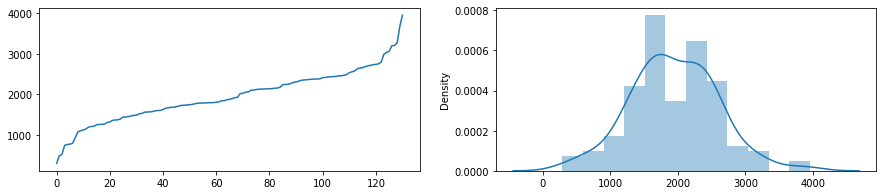

In [ ]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(np.sort(errors))

plt.subplot(1,2,2)
sns.distplot(errors)

In [ ]:
print(abide_subs.shape)
print(D.shape)

(1071,)
torch.Size([131, 1, 64, 64, 64])


In [ ]:
t0 = now()
abide_dx = np.array([np.array(df_abide.loc[df_abide['BIDS_ID']==abide_subs[i]]['Subject Type'])[0] for i in range(len(abide_subs))])
#abide_dx0 = copy.deepcopy(abide_dx)
now()-t0

datetime.timedelta(0, 0, 508297)

In [ ]:
adx = np.repeat(5,D.shape[0])
adx[abide_dx=='PATIENT']=1
adx[abide_dx=='CONTROL']=0

IndexError: ignored

In [ ]:
nsubs_a = D.shape[0]
ds = np.zeros((nsubs_a,2))

ds[:,0] = adx
ds[:,1] = errors
ds

array([[   5.        , 2130.99755859],
       [   5.        , 2129.64746094],
       [   5.        ,  764.13891602],
       [   5.        , 1446.02905273],
       [   5.        , 1479.44274902],
       [   5.        , 1564.41625977],
       [   5.        ,  288.49514771],
       [   5.        , 1436.77185059],
       [   5.        , 2016.56835938],
       [   5.        ,  784.78173828],
       [   5.        ,  756.05645752],
       [   5.        , 1385.35852051],
       [   5.        , 1067.27172852],
       [   5.        , 1787.26757812],
       [   5.        , 2574.79199219],
       [   5.        , 3199.29418945],
       [   5.        , 1810.09960938],
       [   5.        , 2455.66455078],
       [   5.        , 1597.1027832 ],
       [   5.        , 1676.11877441],
       [   5.        , 1777.32104492],
       [   5.        , 1436.25012207],
       [   5.        , 2466.04003906],
       [   5.        , 1098.52026367],
       [   5.        , 2372.47412109],
       [   5.        , 24

In [ ]:
slice_C = np.array(ds[:,1]<10) * np.array(ds[:,0]==0)
slice_A = np.array(ds[:,1]<10) * np.array(ds[:,0]==1)
(sum(slice_A),sum(slice_C))

(0, 0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

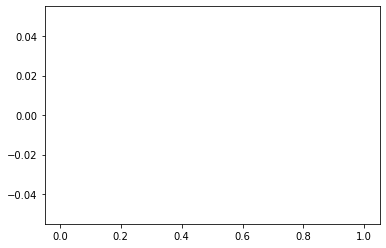

In [ ]:
plt.hist(ds[slice_A,1],alpha=.3)
plt.hist(ds[slice_C,1],alpha=.3)

In [ ]:
#sfari_subs
#SFARI_data
#df_sfari

In [ ]:
#activation = model.lrelu( model.enc_C1(D[batches[1],:,:,:,:]))
activation = model.lrelu( model.enc_C2(activation) )
activation = model.lrelu( model.enc_C3(activation) )

NameError: ignored

In [ ]:
act = list()
for s in range(D.shape[0]):
  act.append(model.lrelu(model.enc_C3(model.lrelu(model.enc_C2(model.lrelu( model.enc_C1(D[s,0,:,:,:][np.newaxis,np.newaxis,:,:,:])))))).flatten().detach().numpy())
print('all done')
act = np.array(act)

all done


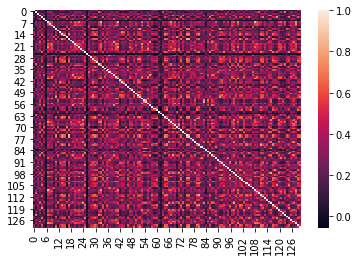

In [ ]:
sns.heatmap(np.corrcoef(act))

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

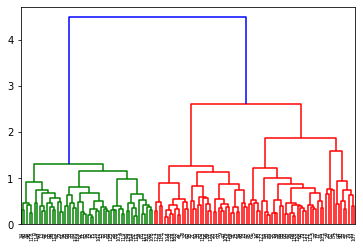

In [ ]:
Y = pdist(act,'correlation')
Z = linkage(Y, 'ward')
dn = dendrogram(Z)

In [ ]:
ord = dn['leaves']

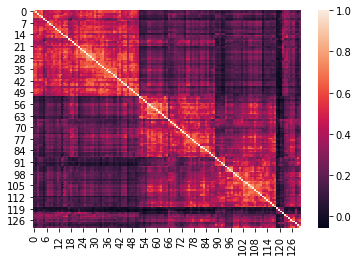

In [ ]:
cmat = np.corrcoef(act)
cmat = cmat[ord,:]
cmat = cmat[:,ord]
sns.heatmap(cmat)

In [ ]:
AA = np.array([D.detach().numpy()[s,0,:,:,:].flatten() for s in range(D.shape[0])])

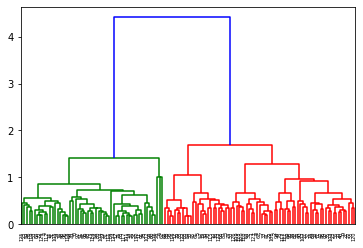

In [ ]:
Y = pdist(AA,'correlation')
Z = linkage(Y, 'ward')
dn = dendrogram(Z)

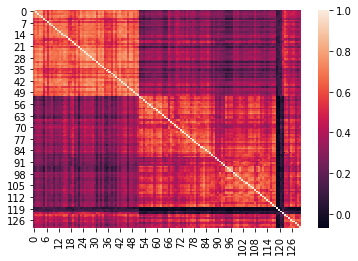

In [ ]:
cmat = np.corrcoef(AA)
cmat = cmat[ord,:]
cmat = cmat[:,ord]
sns.heatmap(cmat)

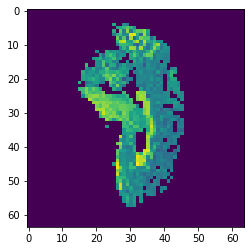

In [ ]:
plt.imshow(Da[750,0,32,:,:])

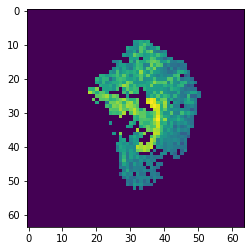

In [ ]:
plt.imshow(D[2,0,32,:,:])

In [ ]:
ord

<function ord>

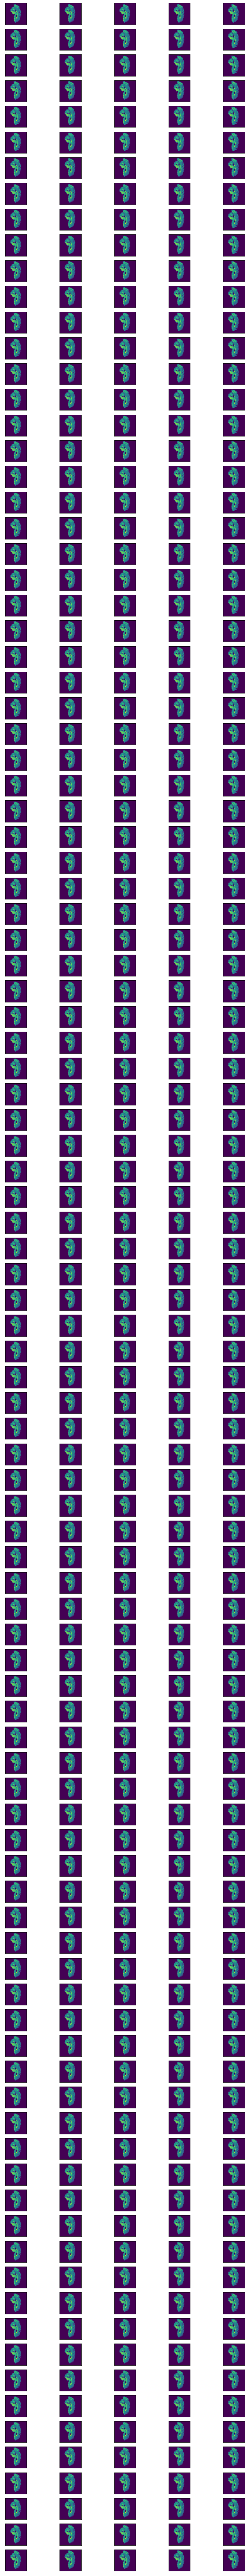

In [ ]:
plt.figure(figsize=(10,100))
nrows = 100
ncols = 5
for i in range(nrows*ncols):
  plt.subplot(100,5,i+1)
  plt.imshow(Da[750,0,32,:,:])
  plt.xticks([]);plt.yticks([])

In [ ]:
print(D.shape)
print(Da.shape)

torch.Size([131, 1, 64, 64, 64])
torch.Size([1071, 1, 64, 64, 64])


In [ ]:
np.array(df_sfari['family_type'])[ord]

array(['non-familial-control', 'non-familial-control',
       'non-familial-control', 'non-familial-control',
       'non-familial-control', '16p-duplication', 'non-familial-control',
       '16p-duplication', '16p-duplication', '16p-duplication',
       '16p-deletion', 'non-familial-control', 'non-familial-control',
       'non-familial-control', 'non-familial-control', '16p-duplication',
       'non-familial-control', '16p-duplication', '16p-deletion',
       'non-familial-control', '16p-deletion', 'non-familial-control',
       'non-familial-control', '16p-duplication', '16p-duplication',
       'non-familial-control', '1q-deletion', '16p-triplication',
       '1q-deletion', '16p-deletion', 'non-familial-control',
       '16p-deletion', 'non-familial-control', '16p-deletion',
       'non-familial-control', 'non-familial-control', '16p-duplication',
       'non-familial-control', 'non-familial-control', '16p-deletion',
       'non-familial-control', 'non-familial-control',
       'no